In [1]:
# Libraries
import matplotlib.pyplot as  plt
import concurrent.futures
import seaborn as sns
import pandas as pd
import json
import os
from  utils import *
from sklearn.model_selection import train_test_split

# Load data

The download of the dataset from kaggle resulted in $10$ folders ("batch_1", "batch_2" and so on) which contained each a folder of images and a .json file containing information for each image (visible classes, boxes for each class, target latex sequence).

In [2]:
# Load all batches json files
selected_batches = range(1,11)
raw_data = []
for batch_id in selected_batches:
  with open(file= f"Ocr-raw-data/batch_{batch_id}/JSON/kaggle_data_{batch_id}.json") as f:
    batch_list = json.load(f)
    batch_list = [{**my_dict, "batch_id": batch_id} for my_dict in batch_list]

    raw_data += batch_list


# Load dictionary that maps each visible latex char to an id
with open(file= "Ocr-raw-data/extras/visible_char_map.json") as f:
    visible_char_map = json.load(f)

In [3]:
# Get a dataframe structure and a list
aida_df, all_latex_lst = create_data_frame(raw_data)

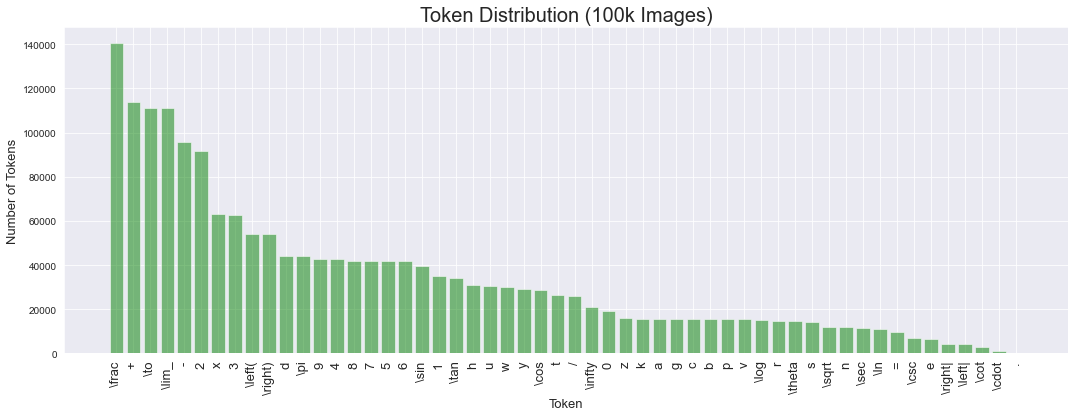

In [4]:
# Plot token distribution
token_df = pd.DataFrame(all_latex_lst, columns =['token'])
token_df['index']=token_df.index
token_count_df = create_count_df(df=token_df, field='token', index='index')
plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', ylabel='Number of Tokens', title=f'Token Distribution (100k Images)')

# Make a more balanced data

There are some classes that have very low occurrences, and others that are really frequent.
Trying to balance a bit this behaviour we decided to drop images containing the less frequent classes (".", "\cdot", "\cot"),
 and to overall decrease the size of our dataset.

In [5]:
# Drop images containing the less frequent classes (".", "\cdot", "\cot")
aida_df = aida_df[[ not ("."  in i or "\cdot"  in i or "\cot"  in i) for i in aida_df["visible_latex_chars"]]]
all_latex_lst = [item for sublist in list(aida_df["visible_latex_chars"]) for item in sublist]
len(aida_df)

96124

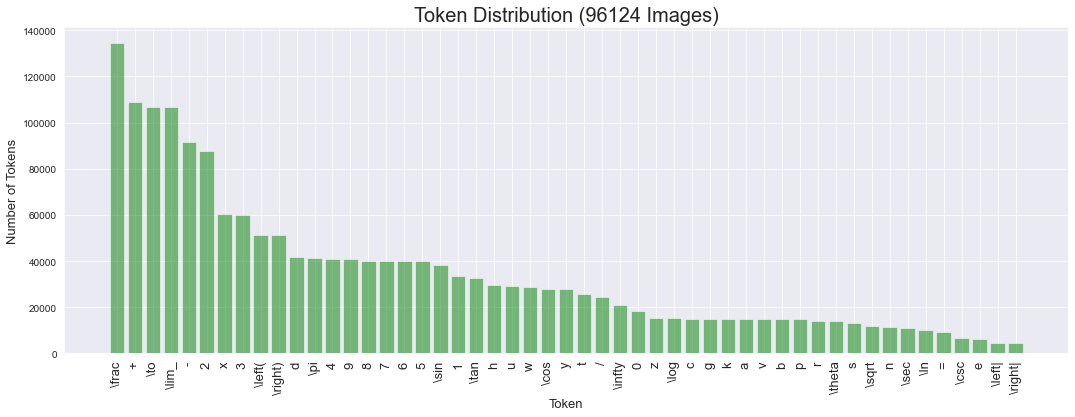

In [6]:
# Plot token distribution
token_df = pd.DataFrame(all_latex_lst, columns =['token'])
token_df['index']=token_df.index
token_count_df = create_count_df(df=token_df, field='token', index='index')
plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', ylabel='Number of Tokens', title=f'Token Distribution ({len(aida_df)} Images)')

In [45]:
# Reduce the size of our dataset in order to make more balanced the ratio between classes.
# We take the images that contains the less frequent classes:
aida_df = aida_df[["\\right|" in i or "e" in i or "\csc" in i or "\sqrt" in i or "\\log" in i or "\sec" in i for i in aida_df["visible_latex_chars"]]]
all_latex_lst = [item for sublist in list(aida_df["visible_latex_chars"]) for item in sublist]
len(aida_df)

37548

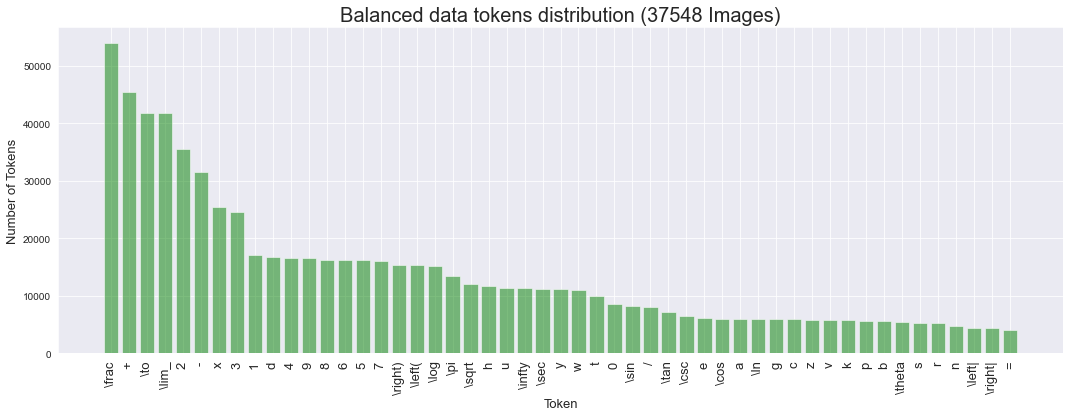

In [8]:
# Plot final token distribution
token_df = pd.DataFrame(all_latex_lst, columns =['token'])
token_df['index']=token_df.index
token_count_df = create_count_df(df=token_df, field ='token', index='index')
plot_count_df(df=token_count_df, field='token', random_sample=False, color='g', rotation=90, xlabel='Token', ylabel='Number of Tokens', title= f'Balanced data tokens distribution ({len(aida_df)} Images)')

In [50]:
# Check our data max_length:
max(aida_df["full_latex_chars"].apply(lambda x: len(x)))

111

We've seen that the longest sequence in our dataset is of 111 symbols.
Since in the lstm part we will have to add also the <END> and <START> tokens, we will consider as max_length 113.

# Data engineering

Both with YOLO and the LSTM we will not work with boxes height and width but with boxes center and so on.
Here we handle those changes:

In [9]:
# Get "x_center", "y_center", "width" and "height" columns
aida_df[["x_center", "y_center", "width", "height"]] = aida_df.apply(process_row, axis = 1, result_type='expand')

# Drop useless columns
columns_to_drop = ['xmins', 'xmaxs', 'ymins', 'ymaxs']
aida_df.drop(columns=columns_to_drop, inplace=True)

In [10]:
aida_df.head()

,filename,batch_id,visible_latex_chars,full_latex_chars,x_center,y_center,width,height
0,bd85ee85-2549-4539-9cd9-122d0ea3dca2.jpg,1,"[\lim_, a, \to, \frac, \pi, 4, \frac, \frac, d...","[\lim_, {, a, \to, \frac, {, \pi, }, {, 4, }, ...","[0.0698608137, 0.01338329765, 0.04122055675, 0...","[0.37802419355, 0.6431451613, 0.65826612905, 0...","[0.124732334, 0.0235546039, 0.0278372590999999...","[0.2560483871, 0.12903225800000007, 0.04233870..."
2,3c72e1a1-c1de-4d67-a0ad-9f7afb6cee01.jpg,1,"[e, \lim_, b, \to, 4, +, \frac, \frac, 7, b, +...","[e, ^, {, \lim_, {, b, \to, 4, ^, {, +, }, }, ...","[0.0483214649, 0.1983723296, 0.33621566635, 0....","[0.7815789473500001, 0.42763157895000004, 0.72...","[0.09053916579999999, 0.1871820956, 0.06612410...","[0.3421052631, 0.36578947370000003, 0.21578947..."
4,da71ce9d-e1a1-4bb2-abce-77a29c45024f.jpg,1,"[=, \lim_, x, \to, 8, +, \frac, -, 9, \tan, x,...","[=, \lim_, {, x, \to, 8, ^, {, +, }, }, \frac,...","[0.015210177, 0.11338495574999999, 0.192477876...","[0.76029411765, 0.68676470585, 0.90147058825, ...","[0.0248893806, 0.0995575221, 0.019911504400000...","[0.14411764710000008, 0.2029411765, 0.12058823..."
8,ee8bc699-e481-4738-80d2-aeade4776033.jpg,1,"[\lim_, g, \to, 9, \frac, \frac, d, d, g, \lef...","[\lim_, {, g, \to, 9, }, \frac, {, \frac, {, d...","[0.0633886256, 0.1537322275, 0.19312796205, 0....","[0.44929245285, 0.6933962264, 0.65683962265, 0...","[0.10781990520000001, 0.0313981042, 0.03554502...","[0.35613207550000003, 0.16509433959999997, 0.0..."
9,436008a6-638f-4bd0-82cf-d696f383eebe.jpg,1,"[\lim_, x, \to, 1, +, -, 7, 1, \csc, x]","[\lim_, {, x, \to, 1, ^, {, +, }, }, -, 7, 1, ...","[0.1409574468, 0.07234042555, 0.11648936169999...","[0.32386363635, 0.92234848485, 0.8560606061, 0...","[0.23510638299999997, 0.027659574500000006, 0....","[0.5416666667, 0.11742424250000005, 0.12878787..."


In [11]:
# Save as json our final dataset
aida_df.to_json('Clean_data/total_data_df.json')

# Modify char_map
The ocr-data provides this "visible_char_map.json", which is a dictionary that maps each symbol visible in the images to an integer.

We will have to create two different char_maps:
- one for the YOLO training, it will contain ONLY chars that are actually visible in the images;
- another one for the LSTM training, which will also contain some special chars and symbols that are present in the latex langauge.

Let's create them:


In [12]:
# Show initial visible_char_map
visible_char_map

{'\\alpha': 1,
 '\\approx': 2,
 '\\beta': 3,
 '\\cdot': 4,
 '\\delta': 5,
 '\\div': 6,
 '\\frac': 7,
 '\\gamma': 8,
 '\\geq': 9,
 '\\infty': 10,
 '\\int': 11,
 '\\left(': 12,
 '\\left[': 13,
 '\\left\\{': 14,
 '\\left|': 15,
 '\\leq': 16,
 '\\neq': 17,
 '\\pi': 18,
 '\\pm': 19,
 '\\prime': 20,
 '\\right)': 21,
 '\\right]': 22,
 '\\right|': 23,
 '\\sqrt': 24,
 '\\theta': 25,
 '+': 26,
 ',': 27,
 '-': 28,
 '.': 29,
 '/': 30,
 '0': 31,
 '1': 32,
 '2': 33,
 '3': 34,
 '4': 35,
 '5': 36,
 '6': 37,
 '7': 38,
 '8': 39,
 '9': 40,
 ';': 41,
 '<': 42,
 '=': 43,
 '>': 44,
 'A': 45,
 'C': 46,
 'F': 47,
 'G': 48,
 'H': 49,
 'L': 50,
 'a': 51,
 'b': 52,
 'c': 53,
 'd': 54,
 'e': 55,
 'f': 56,
 'g': 57,
 'h': 58,
 'k': 59,
 'n': 60,
 'p': 61,
 'r': 62,
 's': 63,
 't': 64,
 'u': 65,
 'v': 66,
 'w': 67,
 'x': 68,
 'y': 69,
 'z': 70,
 '\\lim_': 71,
 '\\log': 72,
 '\\cot': 73,
 '\\csc': 74,
 '\\to': 75,
 '\\cos': 76,
 '\\sec': 77,
 '\\sin': 78,
 '\\ln': 79,
 '\\tan': 80,
 '\\arcsin': 81,
 '\\arccos': 82,


In [13]:
# YOLO char map creation

# Initialize yolo_char_map
yolo_char_map = visible_char_map.copy()

# Store actually visible chars in the images
actually_visible_symbols = list(np.unique(all_latex_lst))

# We need to drop all keys that are not visible
for key in visible_char_map.keys():
    if key not in actually_visible_symbols:
        del yolo_char_map[key]


# Reorder keys from 0 to len(yolo_char_map)  (required by YOLO)
for i, key in enumerate(yolo_char_map.keys()):
    yolo_char_map[key] = i

# Show results
print(yolo_char_map)

{'\\frac': 0, '\\infty': 1, '\\left(': 2, '\\left|': 3, '\\pi': 4, '\\right)': 5, '\\right|': 6, '\\sqrt': 7, '\\theta': 8, '+': 9, '-': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, '=': 22, 'a': 23, 'b': 24, 'c': 25, 'd': 26, 'e': 27, 'g': 28, 'h': 29, 'k': 30, 'n': 31, 'p': 32, 'r': 33, 's': 34, 't': 35, 'u': 36, 'v': 37, 'w': 38, 'x': 39, 'y': 40, 'z': 41, '\\lim_': 42, '\\log': 43, '\\csc': 44, '\\to': 45, '\\cos': 46, '\\sec': 47, '\\sin': 48, '\\ln': 49, '\\tan': 50}


In [14]:
# LSTM char map creation
# We will add special tokens: <PAD>, <START>, <END> and latex related symbols.

# lstm_char_map initialization
lstm_char_map = yolo_char_map.copy()

# We want <PAD> to have the 0 token, hence we add 1 to all the keys
for  key in lstm_char_map.keys():
    lstm_char_map[key] +=1

# Add new tokens
lstm_char_map['PAD'] = 0
lstm_char_map['{'] = len(lstm_char_map)
lstm_char_map['}'] = len(lstm_char_map)
lstm_char_map['^'] = len(lstm_char_map)
lstm_char_map['_'] = len(lstm_char_map)
lstm_char_map['['] = len(lstm_char_map)
lstm_char_map[']'] = len(lstm_char_map)
lstm_char_map['START'] = len(lstm_char_map)
lstm_char_map['END'] = len(lstm_char_map)


# Show results
print(lstm_char_map)

{'\\frac': 1, '\\infty': 2, '\\left(': 3, '\\left|': 4, '\\pi': 5, '\\right)': 6, '\\right|': 7, '\\sqrt': 8, '\\theta': 9, '+': 10, '-': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, '=': 23, 'a': 24, 'b': 25, 'c': 26, 'd': 27, 'e': 28, 'g': 29, 'h': 30, 'k': 31, 'n': 32, 'p': 33, 'r': 34, 's': 35, 't': 36, 'u': 37, 'v': 38, 'w': 39, 'x': 40, 'y': 41, 'z': 42, '\\lim_': 43, '\\log': 44, '\\csc': 45, '\\to': 46, '\\cos': 47, '\\sec': 48, '\\sin': 49, '\\ln': 50, '\\tan': 51, 'PAD': 0, '{': 52, '}': 53, '^': 54, '_': 55, '[': 56, ']': 57, 'START': 58, 'END': 59}


In [15]:
# Save them both as .json files

with open("Clean_data/YOLO/yolo_char_map.json", "w") as json_file:
    json.dump(yolo_char_map, json_file)

with open("Clean_data/LSTM/lstm_char_map.json", "w") as json_file:
    json.dump(lstm_char_map, json_file)


# TEST / TRAIN split

Since we want to create a cascade model (Yolo + LSTM) we need to take a test set where no model will train on.
We decided to keep as a test set $2000$ images.

The other $35548$ images will be used for training testing and validating the two singular models:
- for the YOLO fine-tuning we will use just a portion of this dataset ($5000$ images);
- for the LSTM we will use it all.

In [ ]:
# Load our final dataset
total_data_df = pd.read_json('Clean_data/total_data_df.json')

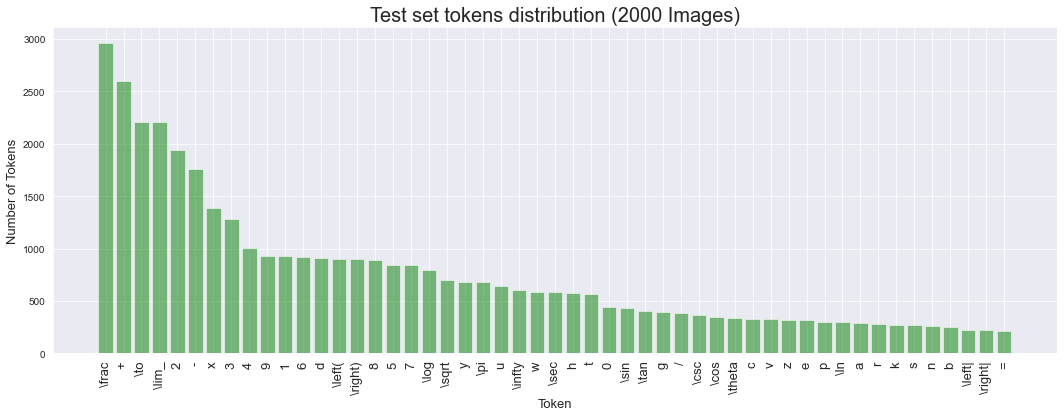

In [3]:
# Create test set and plot its tokens distribution
lstm_total_data_df, test_df = train_test_split(total_data_df, test_size = 2000, random_state = 999)

test_latex_list = [item for sublist in list(test_df["visible_latex_chars"]) for item in sublist]

# Plot final token distribution to check for the presence of all tokens
token_df = pd.DataFrame(test_latex_list, columns =['token'])
token_df['index']=token_df.index
token_count_df = create_count_df(df=token_df, field ='token', index='index')
plot_count_df(df=token_count_df, field='token', random_sample = False, color='g', rotation=90, xlabel='Token', ylabel='Number of Tokens', title= f'Test set tokens distribution ({len(test_df)} Images)')

In [ ]:
# Save test as a dataframe
test_df.to_json('Clean_data/CASCADE_TEST/cascade_test_df.json')

# Save it in YOLO format
YOLO_format_parallel(source_file = 'Ocr-raw-data',
                       dest_file = 'Clean_data/CASCADE_TEST/YOLO_format',
                       dataframe = test_df,
                       char_map= yolo_char_map)

# Save it in LSTM format
lstm_cascade_test = LSTM_process_dataframe(df = test_df,
                               max_length = 113,
                               start_token = lstm_char_map["START"],
                               end_token = lstm_char_map["END"],
                               pad_token = lstm_char_map["PAD"],
                               char_map = lstm_char_map)

savable_lstm_cascade_test = tuple(map(lambda x: x.tolist(), lstm_cascade_test))
with open("Clean_data/CASCADE_TEST/lstm_cascade_test.json", "w") as json_file:
    json.dump(savable_lstm_cascade_test, json_file)


In [5]:

with open("Clean_data/LSTM/lstm_char_map.json") as json_file:
    lstm_char_map = json.load(json_file)

# Save it in LSTM format
lstm_cascade_test = LSTM_process_dataframe(df = test_df,
                               max_length = 113,
                               start_token = lstm_char_map["START"],
                               end_token = lstm_char_map["END"],
                               pad_token = lstm_char_map["PAD"],
                               char_map = lstm_char_map)

savable_lstm_cascade_test = tuple(map(lambda x: x.tolist(), lstm_cascade_test))
with open("Clean_data/CASCADE_TEST/lstm_cascade_test.json", "w") as json_file:
    json.dump(savable_lstm_cascade_test, json_file)


# LSTM data

Here we create the dataset we used in the LSTM training phase.
Each set consists of a tuple containing three numpy arrays:
- (N, max_length) shaped **sequences symbols**;
- (N, max_length, 4)  shaped **sequences features**;
- (N, max_length) shaped **sequences targets**.

An important consideration is that since the **LSTM** gives importance to the **order** of the sequence, we had to decide an order to train it that could be achieved also in the **YOLO** output.

Initially we decided to order each sequence by the **x_center** feature, anyway this led to some errors in the **YOLO** output reordering: some boxes were really close to each-other and a minor difference in the **x_center** calculation would produce different sequences.

Lastly the most robust ordering we could think of was no ordering at all. We decided to just shuffle the symbols ( and related features) order.

In [6]:
# Split train/val/test dataframes
lstm_train_df, lstm_test_df = train_test_split(lstm_total_data_df, test_size = 0.3, random_state = 999)
lstm_val_df, lstm_test_df = train_test_split(lstm_test_df, test_size = 1/3, random_state = 999)

In [7]:
# Get in the right format for the lstm training validating and testing.
# Each object is a tuple containing 3 objects:
#  - Input sequence : N x max_length
#  - Input features : N x max_length x 4
#  - Target sequence: N x max_length

lstm_train = LSTM_process_dataframe(df = lstm_train_df,
                               max_length = 113,
                               start_token = lstm_char_map["START"],
                               end_token = lstm_char_map["END"],
                               pad_token = lstm_char_map["PAD"],
                               char_map = lstm_char_map)


lstm_val = LSTM_process_dataframe(df = lstm_val_df,
                               max_length = 113,
                               start_token = lstm_char_map["START"],
                               end_token = lstm_char_map["END"],
                               pad_token = lstm_char_map["PAD"],
                               char_map = lstm_char_map)

lstm_test = LSTM_process_dataframe(df = lstm_test_df,
                               max_length = 113,
                               start_token = lstm_char_map["START"],
                               end_token = lstm_char_map["END"],
                               pad_token = lstm_char_map["PAD"],
                               char_map = lstm_char_map)

In [8]:
# Remove np.arrays to store a .json files
savable_train = tuple(map(lambda x: x.tolist(), lstm_train))
savable_val = tuple(map(lambda x: x.tolist(), lstm_val))
savable_test = tuple(map(lambda x: x.tolist(), lstm_test))

In [9]:
# Save them as .json files
with open("Clean_data/LSTM/lstm_train.json", "w") as json_file:
    json.dump(savable_train, json_file)

with open("Clean_data/LSTM/lstm_val.json", "w") as json_file:
    json.dump(savable_val, json_file)

with open("Clean_data/LSTM/lstm_test.json", "w") as json_file:
    json.dump(savable_test, json_file)

# YOLO data

Here we create the dataset we used in the YOLO fine-tuning phase.
**YOLO** needs  a specific structure to be trained, for each set (train, val and test) it requires two folders:
 - one containing the images;
 - another one containing the labels associated as files.txt.

In this section we first sample $5000$ images from the $37458$ images dataset, then we create this structure in the "yolo_format_data" folder.

In [10]:
# Here we create a smaller dataframe for training composed of 5000 images
yolo_total_data_df = lstm_total_data_df.sample(5000, random_state = 999)
small_latex_list = [item for sublist in list(yolo_total_data_df["visible_latex_chars"]) for item in sublist]

# Split train/val/test for YOLO fine-tuning
yolo_train_df, yolo_test_df = train_test_split(yolo_total_data_df, test_size = 0.3, random_state = 999)
yolo_val_df, yolo_test_df = train_test_split(yolo_test_df, test_size = 1/3, random_state = 999)

In [2]:
# Save into the yolo format for train / val / test
YOLO_format_parallel(source_file = 'Ocr-raw-data',
                   dest_file = 'Clean_data/YOLO/yolo_format_data/train',
                   dataframe = yolo_train_df,
                   char_map= yolo_char_map)

YOLO_format_parallel(source_file = 'Ocr-raw-data',
                   dest_file = 'Clean_data/YOLO/yolo_format_data/val',
                   dataframe = yolo_val_df,
                   char_map= yolo_char_map)

YOLO_format_parallel(source_file = 'Ocr-raw-data',
                   dest_file = 'Clean_data/YOLO/yolo_format_data/test',
                   dataframe = yolo_test_df,
                   char_map= yolo_char_map)

100%|██████████| 500/500 [00:07<00:00, 69.47it/s] 
